# I want to actually make an LSTM
I will use the data in entero_unique_arg.csv, break each entry up into a list of 14 long characters that move over a space each time. The 15th character will be the one that the neural net is trying to predict. 


For each line of the input data I want to give it a 12 position long random "seed" along with a "start" character which I have decided is ":".

In [109]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import matplotlib.patches as patches


print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.4.0
Keras Version: 2.4.0

Python 3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) 
[GCC 9.4.0]
Pandas 1.3.3
Scikit-Learn 1.0
GPU is NOT AVAILABLE


2022-01-17 11:29:37.322241: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [74]:
import pandas as pd
import numpy as np

np.random.seed(42)
pd.set_option('display.max_rows', 1000)
pd.set_option( 'display.max_colwidth', None )

df = pd.read_csv('data/entero_unique_arg.csv', skiprows=3, names=['sequences'])
FRAG_SIZE = 14
LONGEST_TRNA = max(df['sequences'].map(len))
display(df.head())

,sequences
0,GCATCCGTAGTTCAGTTGGAtAGAGCACTCGGCTACGAACCGAGAGGtCGGAGGTTCAAATCCTTCCGGATGCA
1,GCGCTTGTAGCTCAGTTGGAtAGAGCGCTACCCTCCGAAGGTAGAGGcCTCAGGTTCGAATCCTGTCAAGCGCA
2,GCGCTCTTAGCTCAGATGGAtAGAGCAACGGCCTTCTAAGCCGTAGGtCATAGGTTCGAATCCTATAGAGCGCA
3,GCGCCCTTAGCTCAGTTGGAtAGAGCAACGACCTTCTAAGTCGTGGGcCGCAGGTTCGAATCCTGCAGGGCGCG
4,GTCCTCTTAGTTAAATGGAtATAACGAGCCCCTCCTAAGGGCTAAtTGCAGGTTCGATTCCTGCAGGGGACA


In [76]:
def add_prefix(sequence):
    #prefix = np.random.rand(1,FRAG_SIZE-1).tolist()[0]
    prefix=list((FRAG_SIZE-1)*'R')
    prefix.extend(sequence)
    return prefix

def add_suffix(sequence):
    sequence.append('P')
    return sequence

def split_sequence(sequence):
    return [str(x) for x in sequence]

def make_X(sequence):
    steps = len(sequence)-FRAG_SIZE
    train = []
    for step in range(steps):
        train.append( sequence[step:FRAG_SIZE+step+1] )
    return train
    
def make_y(sequence):
    steps = len(sequence)-FRAG_SIZE+1
    predict = []
    for step in range(steps):
        predict.append( sequence[FRAG_SIZE+step-1] )
    return predict

def make_dummy(item):
    try:
        return uniqueChars[item]
    except KeyError:
        return item
            
def make_one_hot(sequence, categories=['a', 'b', 'c']):
    '''
    Given a list of values, and a list of potential categories
    return a 2D, onehot encoded list of values.
    '''
    shape = ( len(sequence), len(categories) )
    one_hot = np.zeros(shape , dtype=int )
    for n,item in enumerate(sequence):
        index = categories.index(item)
        one_hot[n,index] = 1
    return one_hot

def make_series_cat(series, categories):
    '''
    Given a column of a dataframe, make it a categoricalDtype
    for make_dummies
    '''
    return series.astype(pd.CategoricalDtype(categories=categories))

    
def make_sentence_cat(sentence, categories=list(uniqueChars.keys())):
    sentence = pd.DataFrame(sentence).T
    sentence = sentence.apply(make_series_cat, axis='columns', categories=categories )
    return pd.get_dummies(sentence)

In [77]:
example = [0.3745401188473625,
  0.9507143064099162,
  0.7319939418114051,
  0.5986584841970366,
  0.15601864044243652,
  0.15599452033620265,
  0.05808361216819946,
  0.8661761457749352,
  0.6011150117432088,
  0.7080725777960455,
  0.020584494295802447,
  0.9699098521619943,
  0.8324426408004217,
  ':',
  'G',
  'C',
  'A',
  'T',
  'C',
  'C',
  'G',
  'T',
  'A',
  'G',
  'T',
  'T',
  'C',
  'A',
  'G',
  'T',
  'T',
  'G',
  'G',
  'A',
  't',
  'A',
  'G',
  'A',
  'G',
  'C',
  'A',
  'C',
  'T',
  'C',
  'G',
  'G',
  'C',
  'T',
  'A',
  'C',
  'G',
  'A',
  'A',
  'C',
  'C',
  'G',
  'A',
  'G',
  'A',
  'G',
  'G',
  't',
  'C',
  'G',
  'G',
  'A',
  'G',
  'G',
  'T',
  'T',
  'C',
  'A',
  'A',
  'A',
  'T',
  'C',
  'C',
  'T',
  'T',
  'C',
  'C',
  'G',
  'G',
  'A',
  'T',
  'G',
  'C',
  'A',
  ';']

In [79]:
# I changed this to incorporate the keras pad_sequences function
df['upper_sequences'] = df['sequences'].map( str.upper )
df['split_sequences'] = df['upper_sequences'].map( split_sequence )
df['padded_sequences'] = pad_sequences(df.split_sequences, dtype=object, maxlen=LONGEST_TRNA, padding='post', value='P').tolist()
df['complete_sequences'] = df['padded_sequences'].map( add_prefix )

df.head()

,sequences,upper_sequences,split_sequences,padded_sequences,complete_sequences
0,GCATCCGTAGTTCAGTTGGAtAGAGCACTCGGCTACGAACCGAGAGGtCGGAGGTTCAAATCCTTCCGGATGCA,GCATCCGTAGTTCAGTTGGATAGAGCACTCGGCTACGAACCGAGAGGTCGGAGGTTCAAATCCTTCCGGATGCA,"[G, C, A, T, C, C, G, T, A, G, T, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, A, C, T, C, G, G, C, T, A, C, G, A, A, C, C, G, A, G, A, G, G, T, C, G, G, A, G, G, T, T, C, A, A, A, T, C, C, T, T, C, C, G, G, A, T, G, C, A]","[G, C, A, T, C, C, G, T, A, G, T, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, A, C, T, C, G, G, C, T, A, C, G, A, A, C, C, G, A, G, A, G, G, T, C, G, G, A, G, G, T, T, C, A, A, A, T, C, C, T, T, C, C, G, G, A, T, G, C, A, P]","[R, R, R, R, R, R, R, R, R, R, R, R, R, G, C, A, T, C, C, G, T, A, G, T, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, A, C, T, C, G, G, C, T, A, C, G, A, A, C, C, G, A, G, A, G, G, T, C, G, G, A, G, G, T, T, C, A, A, A, T, C, C, T, T, C, C, G, G, A, T, G, C, A, P]"
1,GCGCTTGTAGCTCAGTTGGAtAGAGCGCTACCCTCCGAAGGTAGAGGcCTCAGGTTCGAATCCTGTCAAGCGCA,GCGCTTGTAGCTCAGTTGGATAGAGCGCTACCCTCCGAAGGTAGAGGCCTCAGGTTCGAATCCTGTCAAGCGCA,"[G, C, G, C, T, T, G, T, A, G, C, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, G, C, T, A, C, C, C, T, C, C, G, A, A, G, G, T, A, G, A, G, G, C, C, T, C, A, G, G, T, T, C, G, A, A, T, C, C, T, G, T, C, A, A, G, C, G, C, A]","[G, C, G, C, T, T, G, T, A, G, C, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, G, C, T, A, C, C, C, T, C, C, G, A, A, G, G, T, A, G, A, G, G, C, C, T, C, A, G, G, T, T, C, G, A, A, T, C, C, T, G, T, C, A, A, G, C, G, C, A, P]","[R, R, R, R, R, R, R, R, R, R, R, R, R, G, C, G, C, T, T, G, T, A, G, C, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, G, C, T, A, C, C, C, T, C, C, G, A, A, G, G, T, A, G, A, G, G, C, C, T, C, A, G, G, T, T, C, G, A, A, T, C, C, T, G, T, C, A, A, G, C, G, C, A, P]"
2,GCGCTCTTAGCTCAGATGGAtAGAGCAACGGCCTTCTAAGCCGTAGGtCATAGGTTCGAATCCTATAGAGCGCA,GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGAGCGCA,"[G, C, G, C, T, C, T, T, A, G, C, T, C, A, G, A, T, G, G, A, T, A, G, A, G, C, A, A, C, G, G, C, C, T, T, C, T, A, A, G, C, C, G, T, A, G, G, T, C, A, T, A, G, G, T, T, C, G, A, A, T, C, C, T, A, T, A, G, A, G, C, G, C, A]","[G, C, G, C, T, C, T, T, A, G, C, T, C, A, G, A, T, G, G, A, T, A, G, A, G, C, A, A, C, G, G, C, C, T, T, C, T, A, A, G, C, C, G, T, A, G, G, T, C, A, T, A, G, G, T, T, C, G, A, A, T, C, C, T, A, T, A, G, A, G, C, G, C, A, P]","[R, R, R, R, R, R, R, R, R, R, R, R, R, G, C, G, C, T, C, T, T, A, G, C, T, C, A, G, A, T, G, G, A, T, A, G, A, G, C, A, A, C, G, G, C, C, T, T, C, T, A, A, G, C, C, G, T, A, G, G, T, C, A, T, A, G, G, T, T, C, G, A, A, T, C, C, T, A, T, A, G, A, G, C, G, C, A, P]"
3,GCGCCCTTAGCTCAGTTGGAtAGAGCAACGACCTTCTAAGTCGTGGGcCGCAGGTTCGAATCCTGCAGGGCGCG,GCGCCCTTAGCTCAGTTGGATAGAGCAACGACCTTCTAAGTCGTGGGCCGCAGGTTCGAATCCTGCAGGGCGCG,"[G, C, G, C, C, C, T, T, A, G, C, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, A, A, C, G, A, C, C, T, T, C, T, A, A, G, T, C, G, T, G, G, G, C, C, G, C, A, G, G, T, T, C, G, A, A, T, C, C, T, G, C, A, G, G, G, C, G, C, G]","[G, C, G, C, C, C, T, T, A, G, C, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, A, A, C, G, A, C, C, T, T, C, T, A, A, G, T, C, G, T, G, G, G, C, C, G, C, A, G, G, T, T, C, G, A, A, T, C, C, T, G, C, A, G, G, G, C, G, C, G, P]","[R, R, R, R, R, R, R, R, R, R, R, R, R, G, C, G, C, C, C, T, T, A, G, C, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, A, A, C, G, A, C, C, T, T, C, T, A, A, G, T, C, G, T, G, G, G, C, C, G, C, A, G, G, T, T, C, G, A, A, T, C, C, T, G, C, A, G, G, G, C, G, C, G, P]"
4,GTCCTCTTAGTTAAATGGAtATAACGAGCCCCTCCTAAGGGCTAAtTGCAGGTTCGATTCCTGCAGGGGACA,GTCCTCTTAGTTAAATGGATATAACGAGCCCCTCCTAAGGGCTAATTGCAGGTTCGATTCCTGCAGGGGACA,"[G, T, C, C, T, C, T, T, A, G, T, T, A, A, A, T, G, G, A, T, A, T, A, A, C, G, A, G, C, C, C, C, T, C, C, T, A, A, G, G, G, C, T, A, A, T, T, G, C, A, G, G, T, T, C, G, A, T, T, C, C, T, G, C, A, G, G, G, G, A, C, A]","[G, T, C, C, T, C, T, T, A, G, T, T, A, A, A, T, G, G, A, T, A, T

In [80]:
X = []
y = []
for sequence in df['complete_sequences']:
    X.extend(make_X(sequence))

In [81]:
X[0]

['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'G', 'C']

In [82]:
columns = [f'X_{x}' for x in range(FRAG_SIZE)]
columns.append('y')

dataset = pd.DataFrame(X, columns=columns)
display(dataset.head())
dataset.shape

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,y
0,R,R,R,R,R,R,R,R,R,R,R,R,R,G,C
1,R,R,R,R,R,R,R,R,R,R,R,R,G,C,A
2,R,R,R,R,R,R,R,R,R,R,R,G,C,A,T
3,R,R,R,R,R,R,R,R,R,R,G,C,A,T,C
4,R,R,R,R,R,R,R,R,R,G,C,A,T,C,C


(16428, 15)

In [83]:
# Just looking how many tRNAs start with each letter
dataset[ dataset['X_12']=='R' ].groupby('X_13')['y'].count()

X_13
A      3
C     11
G    202
T      6
Name: y, dtype: int64

In [84]:
# Lets get the basic stats that Jeff was getting
chars = df['complete_sequences'].map(lambda calc: len(calc)).sum()
uniqueChars = {'R': 0, 'A': 1, 'T': 2, 'G':3, 'C':4, 'P':5}
uniqueNums = {value:key for key, value in uniqueChars.items()}
display(uniqueNums)
uniqueChars

{0: 'R', 1: 'A', 2: 'T', 3: 'G', 4: 'C', 5: 'P'}

{'R': 0, 'A': 1, 'T': 2, 'G': 3, 'C': 4, 'P': 5}

In [85]:
# scikit-learn kinda sucks, lets test out our own ratchet function
display( list(uniqueChars.keys()) )
make_one_hot(X[0], categories=list(uniqueChars.keys()) )

['R', 'A', 'T', 'G', 'C', 'P']

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0]])

In [86]:
# Lets one-hot using pandas .make_dummy function rather than make up our own shit :\
# https://stackoverflow.com/questions/37425961/dummy-variables-when-not-all-categories-are-present
# This post makes it seem rather possible, and wow it worked great!

dataset = dataset.apply( make_series_cat, axis = 'columns', categories=list(uniqueChars.keys()) )
dataset = pd.get_dummies(dataset)

In [206]:
dataset.to_csv('data/processed_LSTM_dataset_one_hot.csv', index=False)

In [87]:
dataset.head()

,X_0_R,X_0_A,X_0_T,X_0_G,X_0_C,X_0_P,X_1_R,X_1_A,X_1_T,X_1_G,...,X_13_T,X_13_G,X_13_C,X_13_P,y_R,y_A,y_T,y_G,y_C,y_P
0,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0


# I HAVE MADE MY DATASET
Now lets train the LSTM finally!!!

In [88]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import get_file
#from tensorflow.python.ops.math_ops import reduce_prod
import numpy as np
import pandas as pd
import random
import sys
import io
import requests
import re

In [89]:
df = pd.read_csv('data/processed_LSTM_dataset_one_hot.csv')
display(df.head())
df.shape

,X_0_R,X_0_A,X_0_T,X_0_G,X_0_C,X_0_P,X_1_R,X_1_A,X_1_T,X_1_G,...,X_13_T,X_13_G,X_13_C,X_13_P,y_R,y_A,y_T,y_G,y_C,y_P
0,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0


(16428, 90)

In [90]:
#df = df.astype({'X_13':'float64'})
df.dtypes

X_0_R     int64
X_0_A     int64
X_0_T     int64
X_0_G     int64
X_0_C     int64
X_0_P     int64
X_1_R     int64
X_1_A     int64
X_1_T     int64
X_1_G     int64
X_1_C     int64
X_1_P     int64
X_2_R     int64
X_2_A     int64
X_2_T     int64
X_2_G     int64
X_2_C     int64
X_2_P     int64
X_3_R     int64
X_3_A     int64
X_3_T     int64
X_3_G     int64
X_3_C     int64
X_3_P     int64
X_4_R     int64
X_4_A     int64
X_4_T     int64
X_4_G     int64
X_4_C     int64
X_4_P     int64
X_5_R     int64
X_5_A     int64
X_5_T     int64
X_5_G     int64
X_5_C     int64
X_5_P     int64
X_6_R     int64
X_6_A     int64
X_6_T     int64
X_6_G     int64
X_6_C     int64
X_6_P     int64
X_7_R     int64
X_7_A     int64
X_7_T     int64
X_7_G     int64
X_7_C     int64
X_7_P     int64
X_8_R     int64
X_8_A     int64
X_8_T     int64
X_8_G     int64
X_8_C     int64
X_8_P     int64
X_9_R     int64
X_9_A     int64
X_9_T     int64
X_9_G     int64
X_9_C     int64
X_9_P     int64
X_10_R    int64
X_10_A    int64
X_10_T  

In [91]:
df.head()

,X_0_R,X_0_A,X_0_T,X_0_G,X_0_C,X_0_P,X_1_R,X_1_A,X_1_T,X_1_G,...,X_13_T,X_13_G,X_13_C,X_13_P,y_R,y_A,y_T,y_G,y_C,y_P
0,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [70]:
#Lets vectorize this (or not)
#We can also just leave it as our numbers

In [92]:
featureLength = df.shape[0]
timeStepLength = FRAG_SIZE
concurrentFeatureLength = 1
print('Rolls of film: {}\nInteresting sections per film: {}\nConcurrent films: {}'.format(featureLength, timeStepLength, concurrentFeatureLength))
#dataList = list(df.values.tolist())

Rolls of film: 16428
Interesting sections per film: 14
Concurrent films: 1


In [72]:
#print('Vectorization')
#x = np.zeros(( rowLength, inputLength, outputLength ), dtype=object)
#y = np.zeros(( rowLength, outputLength ), dtype=object)

#for i, sentence in enumerate(dataList):
#    sentence = sentence[:-1]
#    nextChar = sentence[-1]
#    for t, char in enumerate(sentence):
#        x[i,t,uniqueChars[char]] = 1
#    y[i,uniqueChars[nextChar]]

In [93]:
mask = df.columns.str.contains('X')
mask_y = df.columns.str.contains('y')
X = np.array( list(df.loc[:,mask].values.tolist()), dtype='int64' )
y = np.array( list(df.loc[:,mask_y].values.tolist()) )

In [94]:
display(uniqueChars.keys())
y[0:5,]

dict_keys(['R', 'A', 'T', 'G', 'C', 'P'])

array([[0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0]])

In [74]:
# I think this is why y=/=10, it is because ':' never appears in the y column, so outputdim is actually 9!
display(X.shape)
display(y[0])
print(df['y'].values.tolist()[0], uniqueChars['G'])
df.groupby('y')['y'].count().to_dict()
{uniqueNums[key]:value for key, value in df.groupby('y')['y'].count().to_dict().items()}

(16519, 14)

array([0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)

3 3


{'A': 3554,
 'T': 3251,
 'G': 4768,
 'C': 4278,
 'a': 10,
 't': 416,
 'g': 3,
 'c': 17,
 ';': 222}

The above stuff shows the spread of each of the different characters in the neural nets vocabulary. Strange that it never says C considering that is its second highest vocab
===

The way I understand this next part is that
* samples: well how many samples there are
* timesteps: Having vectorized the data, how many points before the one we trying to predict
* features: This one is a bit tough, but I think it has to do with dummy variables

In [95]:
#                 samples,   timesteps,  features   ::: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
X = np.reshape(X, (X.shape[0], FRAG_SIZE, len(uniqueChars)))

# Here is we actually frame the probelm
I followed Jeff Heaton, and he had a categorical problem. But...I think if I change how my y is, I can frame this as a regression! So I would have one output neuron and I would use a different loss function, like maybe RMS or sum of square roots whatever (gonna have to rewatch his vid)

In [150]:
print('Build model')
model = Sequential()
model.add(LSTM(128, input_shape=(14, 6)))
#model.add( Dense(128, activation="relu" ) )
model.add( Dense(6, activation='softmax') )

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model


In [151]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               69120     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 69,894
Trainable params: 69,894
Non-trainable params: 0
_________________________________________________________________


In [152]:

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1,preds,1)
    return np.argmax(probas)

'''
Process to make a sentence into an input for this model
'''
sentence = list((FRAG_SIZE-1) * 'R')
sentence.append('G')
#sentence = pd.DataFrame(sentence).T
#sentence = sentence.apply(make_series_cat, axis='columns', categories=list(uniqueChars.keys()) )
#sentence = pd.get_dummies(sentence)
np.array(make_sentence_cat(sentence)).reshape(1, timeStepLength, len(uniqueChars))
#sentence

array([[[1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]]], dtype=uint8)

In [153]:
# Left off at 16:31 of the lstm generate text video...
print(uniqueChars)
print(uniqueNums)
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print("******************************************************")
    print('----- Generating text after Epoch: %d' % epoch)

    #start_index = random.randint(0, len(processed_text) - maxlen - 1)
    for temperature in [0.4, 0.6, 0.8, 1.0, 1.2]:
        print('----- temperature:', temperature)

        generated = ''
        
        sentence = list((FRAG_SIZE-1) * 'R')
        sentence.append('G')
        print(f'Sentence: {sentence}')
        
        print(f'----- Generating with seed: "{sentence}"')
        #sys.stdout.write(sentence)
        for i in range(80):
            x_pred = np.array(make_sentence_cat(sentence)).reshape(1, timeStepLength, len(uniqueChars))
            preds = model.predict(x_pred, verbose=0)[0]
            
            next_index = sample(preds, temperature)
            next_char = uniqueNums[next_index]

            generated += next_char
            sentence.append(next_char)
            sentence = sentence[1:]
            
            #print(sentence)
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

{'R': 0, 'A': 1, 'T': 2, 'G': 3, 'C': 4, 'P': 5}
{0: 'R', 1: 'A', 2: 'T', 3: 'G', 4: 'C', 5: 'P'}


In [ ]:
# Ignore useless W0819 warnings generated by TensorFlow 2.0.  Hopefully can remove this ignore in the future.
# See https://github.com/tensorflow/tensorflow/issues/31308
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Fit the model
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

epochs=20
history = model.fit(X, y,
          batch_size=50, # 50 was pretty good
          epochs=epochs,     # 20 was pretty good
          callbacks=[print_callback])

Epoch 1/20
329/329 [==============================] - 7s 15ms/step - loss: 1.3065
******************************************************
----- Generating text after Epoch: 0
----- temperature: 0.4
Sentence: ['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'G']
----- Generating with seed: "['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'G']"
CGCCATTAGCTCAGTTGGATAGAGCAACGGCTACAAAGCGTTCGATCAAACGGGTAGAGCGAGCGGCTAGGGTCCAAGGT
----- temperature: 0.6
Sentence: ['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'G']
----- Generating with seed: "['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'G']"
TTCCGTAGCTCAGCTGGATAGAGCAACGGCTATAAAGCGATCGAGCTACAGGTCAAAGGTACAAAGCACTGCCTCAGCTG
----- temperature: 0.8
Sentence: ['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'G']
----- Generating with seed: "['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'G']"
CGCCCTTAGCTCAGCTGGATAGAGCAACGGACATAGCGAGCTGAACGAA

In [107]:
# I am able to create tRNAs, and even pseudogenes that are bacterial looking even
# when I have a loss of 0.3. I ran some of my lower-temp results through blast
# and was getting hits to Arg-tRNAs outside of my enterobacterales training set
# but that might have been just because that tRNA is well conserved. 

# tRNASCAN-se was also saying I'm producing Arg-tRNAs, so that is nice. The higher
# temp (more random) sequences were producing pseudogenes of Arg-tRNAs.

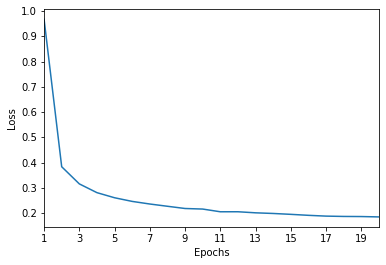

In [157]:
plt.xlim(1,epochs)
plt.xticks(np.arange(1,epochs,2))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1,epochs+1),history.history['loss'])

In [156]:
model.save('./LSTM_models/Arg_tRNA_generator_v1')

In [177]:
sentence = list(FRAG_SIZE * 'R')
sentence = np.array(make_sentence_cat(sentence)).reshape(1, timeStepLength, len(uniqueChars))
uniqueNums[ np.argmax( model.predict(sentence, verbose=0) ) ]

'T'